# Random Forest NER

In [1]:
import random
from faker import Faker

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

## Generate data

In [2]:
LOCS = ['fr_FR', 'fr_FR', 'fr_FR', 'en_US', 'en_GB', 'de_DE', 'fr_CH', 'nl_BE', 'it_IT', 'es_ES']
fake = {loc:Faker(loc) for loc in LOCS}
Faker.seed(1909)

DATASET_SIZE = 10000

In [3]:
adrs = []

for i in range(DATASET_SIZE):
    words, tags = [],[]
    loc = random.sample(LOCS,1)[0]
    
    if random.random()>0.33: #60% to have bank identifier
        if random.random() > 0.8:
            ban = fake[loc].iban().split() #80% iban
        else:
            ban = fake[loc].bban().split() #20% bban
        for f in ban:       
            if random.random()>0.9: #10% ban splited
                words.append(f[:2])
                tags.append('IBAN')
                words.append(f[2:6])
                tags.append('IBAN')
                words.append(f[6:10])
                tags.append('IBAN')
                words.append(f[10:])
                tags.append('IBAN')
            else:
                words.append(f)
                tags.append('IBAN')
        
    if random.random() > 0.5: #50% individual
        if random.random() > 0.5:
            for f in fake[loc].name().split():
                words.append(f)
                tags.append('NAME')
        else:
            for f in fake[loc].name().split(): #50% not capital letter
                words.append(f.lower())
                tags.append('NAME')
    else: #50% corporate
        for f in fake[loc].company().split():
            words.append(f)
            tags.append('ORG')
    
    if random.random() > 0.1: #90% to have an adress
        for f in fake[loc].address().split():
            if random.random()>0.1:
                words.append(f)
                tags.append('ADDRESS')
    
    if random.random()>0.4: #60% to have country ISO added
        words.append(loc[-2:])
        tags.append('ADDRESS')
    
    if random.random()>0.5: #50% to full capitalize
        words = [w.upper() for w in words]
        
    adrs.append((words,tags))

In [4]:
pd.DataFrame(adrs).head()

,0,1
0,"[Brigitte, Sorgatz, 6, 13406, Starnberg]","[NAME, NAME, ADDRESS, ADDRESS, ADDRESS]"
1,"[GB41RAIT97686957227470, Miss, Ruth, Oliver, S...","[IBAN, NAME, NAME, NAME, ADDRESS, ADDRESS, ADD..."
2,"[DRRJ69739212351658, Padilla, LLC, 464, Quinn,...","[IBAN, ORG, ORG, ADDRESS, ADDRESS, ADDRESS, AD..."
3,"[79730304421419780582283, Allard, 33,, bouleva...","[IBAN, ORG, ADDRESS, ADDRESS, ADDRESS, ADDRESS]"
4,"[445129678259894441, Salz, KGaA, Weinhagegasse...","[IBAN, ORG, ORG, ADDRESS, ADDRESS, ADDRESS, AD..."


## Building features

In [5]:
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

In [6]:
data = []

for i,adr in enumerate(adrs):
    adr_pad = ['<BEGIN>']+adr[0]+['<END>']
    adr_tok = [adr_pad[i:i+3] for i in range(len(adr[0]))]
    for ii,(triplet,tag) in enumerate(zip(adr_tok,adr[1])):
        prev_word, word, next_word = triplet
        d = {
            "adr_idx":i,
            "word_pos":ii,
            "word_pos_percent": ii/len(adr[0]),
            "tag":tag,
            
            "adr_len": len(adr[0]),
            
            "word":word,  
            "prev_word":prev_word,
            "next_word":next_word,
            
            "prev_word_len":len(word),
            "word_len":len(prev_word),
            "next_word_len":len(next_word),
            
            "word_islower":word.islower(),
            "word_isupper":word.isupper(),
            "word_istitle":word.istitle(),
            "word_isdigit":word.isdigit(),
            "word_isalpha":word.isalpha(),
            "word_hasDigit":has_numbers(word),

            "prev_word_islower":word.islower(),
            "prev_word_isupper":word.isupper(),
            "prev_word_istitle":word.istitle(),
            "prev_word_isdigit":word.isdigit(),
            "prev_word_isalpha":word.isalpha(),
            "prev_word_hasDigit":has_numbers(word),

            "next_word_islower":word.islower(),
            "next_word_isupper":word.isupper(),
            "next_word_istitle":word.istitle(),
            "next_word_isdigit":word.isdigit(),
            "next_word_isalpha":word.isalpha(),
            "next_word_hasDigit":has_numbers(word),
        }
        data.append(d)
df = pd.DataFrame(data)
df.head()    

,adr_idx,word_pos,word_pos_percent,tag,adr_len,word,prev_word,next_word,prev_word_len,word_len,...,prev_word_istitle,prev_word_isdigit,prev_word_isalpha,prev_word_hasDigit,next_word_islower,next_word_isupper,next_word_istitle,next_word_isdigit,next_word_isalpha,next_word_hasDigit
0,0,0,0.0,NAME,5,Brigitte,<BEGIN>,Sorgatz,8,7,...,True,False,True,False,False,False,True,False,True,False
1,0,1,0.2,NAME,5,Sorgatz,Brigitte,6,7,8,...,True,False,True,False,False,False,True,False,True,False
2,0,2,0.4,ADDRESS,5,6,Sorgatz,13406,1,7,...,False,True,False,True,False,False,False,True,False,True
3,0,3,0.6,ADDRESS,5,13406,6,Starnberg,5,1,...,False,True,False,True,False,False,False,True,False,True
4,0,4,0.8,ADDRESS,5,Starnberg,13406,<END>,9,5,...,True,False,True,False,False,False,True,False,True,False


## Baseline 

In [7]:
X = df.drop(columns=['adr_idx', 'tag','word','prev_word','next_word'])

y = df['tag']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [9]:
clf = RandomForestClassifier(random_state=0)
scores = cross_val_score(clf, X, y, cv=5, scoring="f1_weighted")
print(np.mean(scores), " +/- ", np.std(scores))

0.9093434979938342  +/-  0.001438197598465379


In [10]:
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test)

In [11]:
df_stats = pd.DataFrame({'preds':test_preds, 'targets':y_test})
df_stats["success"] = pd.to_numeric(df_stats.preds == df_stats.targets)
df_stats.groupby('preds').mean()

C:\Users\Shadow\AppData\Local\Temp\ipykernel_7876\39364010.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_stats.groupby('preds').mean()


,success
preds,
ADDRESS,0.960007
IBAN,0.995937
NAME,0.749776
ORG,0.778205


## additional studies

In [12]:
import time
import numpy as np
from sklearn.inspection import permutation_importance

feature_names = X.columns
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 68.086 seconds


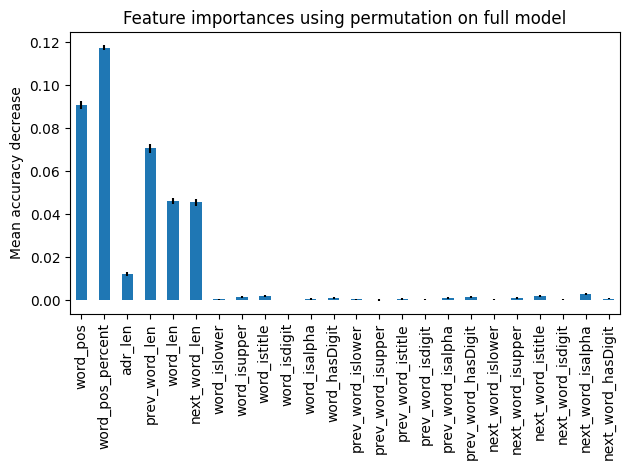

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [14]:
from collections import Counter
all_words = [w for adr in adrs for w in adr[0] if len(w)>2]
voc_count = Counter(all_words).most_common(20)
imp_words = {'ORG':[], 'ADDRESS':[], 'IBAN':[], 'NAME':[]}
for w,c in voc_count:
    tags = df[df.word==w].tag.value_counts().index.values
    if len(tags)==1:
        imp_words[tags[0]].append(w)
print(imp_words)

{'ORG': ['and', 'AND', 'S.A.', 'S.A.R.L.', 'SARL', 'S.A.S.'], 'ADDRESS': ['rue', 'RUE', 'chemin', 'boulevard', 'AVENUE', 'CHEMIN', 'BOULEVARD', 'avenue', 'Apt.', 'Sainte', 'APT.', 'SAINTE', 'Saint', 'SAINT'], 'IBAN': [], 'NAME': []}


In [15]:
data = []
for i,adr in enumerate(adrs):
    adr_pad = ['<BEGIN>']+adr[0]+['<END>']
    adr_tok = [adr_pad[i:i+3] for i in range(len(adr[0]))]
    for ii,(triplet,tag) in enumerate(zip(adr_tok,adr[1])):
        prev_word, word, next_word = triplet
        d = {
            "adr_idx":i,
            "word_pos":ii,
            "word_pos_percent": ii/len(adr[0]),
            "tag":tag,
            
            "adr_len": len(adr[0]),
            
            "word":word,  
            "prev_word":prev_word,
            "next_word":next_word,
            
            "prev_word_len":len(word),
            "word_len":len(prev_word),
            "next_word_len":len(next_word),
            
            "word_isalpha":word.isalpha(),
            "prev_word_isalpha":prev_word.isalpha(),
            "next_word_isalpha":next_word.isalpha(),
            
            "prev_word_adr": word in imp_words['ADDRESS'],
            "word_adr": prev_word in imp_words['ADDRESS'],
            "next_word_adr": next_word in imp_words['ADDRESS'],
            
            "prev_word_org": word in imp_words['ORG'],
            "word_org": prev_word in imp_words['ORG'],
            "next_word_org": next_word in imp_words['ORG'],
        }
        data.append(d)
df = pd.DataFrame(data)
df.head()   

,adr_idx,word_pos,word_pos_percent,tag,adr_len,word,prev_word,next_word,prev_word_len,word_len,next_word_len,word_isalpha,prev_word_isalpha,next_word_isalpha,prev_word_adr,word_adr,next_word_adr,prev_word_org,word_org,next_word_org
0,0,0,0.0,NAME,5,Brigitte,<BEGIN>,Sorgatz,8,7,7,True,False,True,False,False,False,False,False,False
1,0,1,0.2,NAME,5,Sorgatz,Brigitte,6,7,8,1,True,True,False,False,False,False,False,False,False
2,0,2,0.4,ADDRESS,5,6,Sorgatz,13406,1,7,5,False,True,False,False,False,False,False,False,False
3,0,3,0.6,ADDRESS,5,13406,6,Starnberg,5,1,9,False,False,True,False,False,False,False,False,False
4,0,4,0.8,ADDRESS,5,Starnberg,13406,<END>,9,5,5,True,False,False,False,False,False,False,False,False


In [16]:
X = df.drop(columns=['adr_idx', 'tag','word','prev_word','next_word'])
y = df.tag

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [18]:
clf = RandomForestClassifier(random_state=0)
scores = cross_val_score(clf, X, y, cv=5, scoring="f1_weighted")
print(np.mean(scores), " +/- ", np.std(scores))

0.9406806180001543  +/-  0.0022983489883825602


In [19]:
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test)

df_stats = pd.DataFrame({'preds':test_preds, 'targets':y_test})
df_stats["accuracy"] = pd.to_numeric(df_stats.preds == df_stats.targets)
df_stats.groupby('preds').mean()

C:\Users\Shadow\AppData\Local\Temp\ipykernel_7876\3535729278.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_stats.groupby('preds').mean()


,success
preds,
ADDRESS,0.974166
IBAN,0.988479
NAME,0.816847
ORG,0.875385
